In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:

from dataclasses import replace
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.analysis import coherence
from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset

In [33]:
model_dir = "outputs/models/timit/w2v2_6/rnn_8/phoneme"
output_dir = "outputs/notebooks/timit/w2v2_6/rnn_8/phoneme/plot"
dataset_path = "outputs/preprocessed_data/timit"
equivalence_path = "outputs/equivalence_datasets/timit/w2v2_6/phoneme/equivalence.pkl"
hidden_states_path = "outputs/hidden_states/timit/w2v2_6/hidden_states.pkl"
state_space_specs_path = "outputs/state_space_specs/timit/w2v2_6/state_space_specs.pkl"
embeddings_path = "outputs/model_embeddings/timit/w2v2_6/rnn_8/phoneme/embeddings.npy"

output_dir = "."

metric = "cosine"

In [34]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
with open(equivalence_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = torch.load(f)
with open(state_space_specs_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = torch.load(f)["phoneme_by_syllable_position_and_identity"]
assert state_space_spec.is_compatible_with(model_representations)

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

## Search for well-attested phonemes

In [37]:
# Build representation of all phoneme identities/positions
all_phonemes = sorted(set(phoneme for phoneme, position in state_space_spec.labels))
all_positions = sorted(set(position for phoneme, position in state_space_spec.labels if position is not None))
phoneme_mat = np.zeros((len(all_phonemes), len(all_positions)), dtype=int)
for i, (phoneme, position) in enumerate(state_space_spec.labels):
    if position is None:
        continue
    phoneme_mat[all_phonemes.index(phoneme), all_positions.index(position)] = \
        len(state_space_spec.target_frame_spans[i])
phoneme_df = pd.DataFrame(phoneme_mat, index=all_phonemes, columns=all_positions)
phoneme_df

,0,1,2,3,4,5,6
AA,2624,313,115,11,1,0,0
AE,3592,322,69,16,0,0,0
AH,4987,1808,853,280,124,27,1
AO,2580,318,33,7,2,0,0
AW,561,165,5,0,0,0,0
AY,1939,307,130,19,1,2,0
B,1657,500,183,45,26,1,0
CH,596,190,50,6,0,0,0
D,3984,1212,448,100,31,3,0
DH,2652,150,26,1,0,0,0


In [38]:
# Find phonemes which appear in every ordinal position at least twice up to `min_number_positions`
min_number_positions = 3
phoneme_max_position = (phoneme_df >= 2).idxmin(axis=1)
match_phonemes = phoneme_max_position.loc[phoneme_max_position >= min_number_positions].index.tolist()
len(match_phonemes), match_phonemes[:5]

(40, ['AA', 'AE', 'AH', 'AO', 'AW'])

<Axes: xlabel='ordinal_position', ylabel='frequency'>

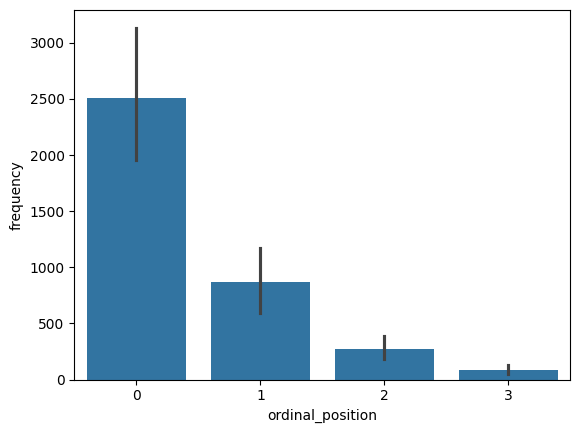

In [39]:
sns.barplot(data=phoneme_df.loc[match_phonemes, :min_number_positions] \
                    .melt(var_name="ordinal_position", value_name="frequency"),
            x="ordinal_position", y="frequency")

## Prepare model representations

In [41]:
retain_labels = [(phoneme, ordinal) for phoneme in match_phonemes
                 for ordinal in range(min_number_positions)]
drop_idxs = [idx for idx, label in enumerate(state_space_spec.labels)
             if label not in retain_labels]
state_space_spec = state_space_spec.drop_labels(drop_idxs)

In [42]:
spec_label_strs = [f"{phone} {ordinal}" for phone, ordinal in state_space_spec.labels]

In [43]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]
len(trajectory)

## Estimate within-phoneme, within-position distance

In [47]:
within_distance, within_distance_offset = \
    coherence.estimate_within_distance(trajectory, lengths, state_space_spec, metric=metric)

  0%|          | 0/120 [00:00<?, ?it/s]

<Axes: >

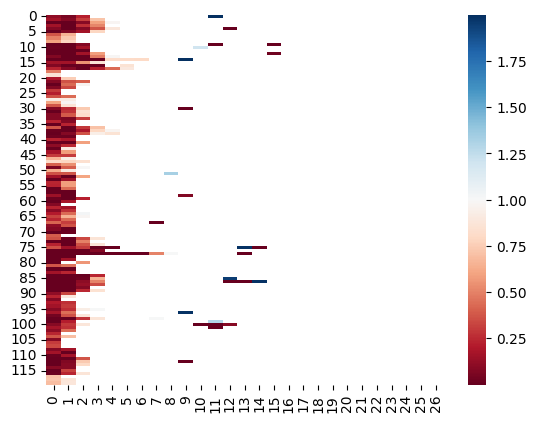

In [48]:
sns.heatmap(within_distance, center=1, cmap="RdBu")

In [49]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

In [ ]:
within_distance_offset_df = pd.DataFrame(within_distance_offset, index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

## Estimate within-phoneme, between-position distance

In [51]:
between1_samples = [[state_space_spec.labels.index((phoneme_i, ordinal_j))
                     for ordinal_j in range(min_number_positions)
                     if ordinal_j != ordinal_i]
                    for phoneme_i, ordinal_i in state_space_spec.labels]

between1_distances, between1_distances_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        between1_samples, metric=metric)

  0%|          | 0/120 [00:00<?, ?it/s]

/tmp/ipykernel_1465306/904010836.py:4: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthie/om2/miniconda/envs/ideal/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [52]:
between1_distances_df = pd.DataFrame(np.nanmean(between1_distances, axis=-1),
                                     index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

/tmp/ipykernel_1465306/2302145081.py:1: RuntimeWarning: Mean of empty slice
  between1_distances_df = pd.DataFrame(np.nanmean(between1_distances, axis=-1),


In [ ]:
between1_distances_offset_df = pd.DataFrame(np.nanmean(between1_distances_offset, axis=-1),
                                     index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

## Estimate between-phoneme distance

In [54]:
# Match the number of between-samples with the earlier analysis
num_samples = min_number_positions

between_distances, between_distances_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        num_samples=num_samples, metric=metric)

  0%|          | 0/120 [00:00<?, ?it/s]

/tmp/ipykernel_1465306/904010836.py:4: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthie/om2/miniconda/envs/ideal/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [55]:
between_distances_df = pd.DataFrame(np.nanmean(between_distances, axis=-1),
                                    index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

/tmp/ipykernel_1465306/1293829715.py:1: RuntimeWarning: Mean of empty slice
  between_distances_df = pd.DataFrame(np.nanmean(between_distances, axis=-1),


In [ ]:
between_distances_offset_df = pd.DataFrame(np.nanmean(between_distances_offset, axis=-1),
                                    index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

## Together

In [57]:
merged_df = pd.concat([within_distance_df.assign(type="within"),
                       between1_distances_df.assign(type="different_position"),
                       between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

,phoneme,frame,distance,type
0,AA 0,0,0.115257,within
1,AA 1,0,0.156911,within
2,AA 2,0,0.003139,within
3,AE 0,0,0.162364,within
4,AE 1,0,0.084634,within
...,...,...,...,...
3235,ZH 1,26,NaN,between
3236,ZH 2,26,NaN,between
3237,[SIL] 0,26,NaN,between
3238,[SIL] 1,26,NaN,between


(0.0, 9.0)

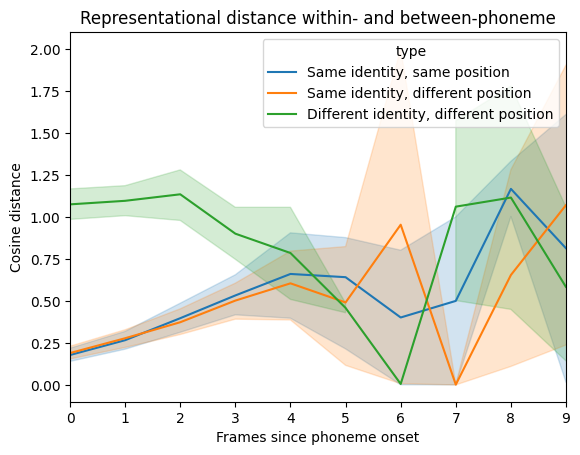

In [58]:
ax = sns.lineplot(data=merged_df.dropna().replace({"type": {"within": "Same identity, same position",
                                                            "different_position": "Same identity, different position",
                                                            "between": "Different identity, different position"}}),
                  x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-phoneme")
ax.set_xlabel("Frames since phoneme onset")
ax.set_ylabel(f"{metric.capitalize()} distance")
ax.set_xlim((0, np.percentile(np.concatenate(lengths), 95)))

In [ ]:
merged_offset_df = pd.concat([within_distance_offset_df.assign(type="within"),
                       between1_distances_offset_df.assign(type="different_position"),
                       between_distances_offset_df.assign(type="between")])
merged_offset_df.to_csv(Path(output_dir) / "distances_aligned_offset.csv", index=False)
merged_offset_df